# What is this notebook about?

This notebook is devoted to the problem of subionospheric points (SIP) localization and selection for the region of interest. For sake of generality method described in this notebook will rely on **Navigational** files instead of **Observational** files. This approach makes processing univeral only location of the receiver is needed, but gives the optimal solution (top estimate of data availability): real receiver could not observe the this satellite or data products may not be calculated for this satelitte. 

To illustrate our objective lets use figure below. 

On the left panel we demostrate the GNSS measurements geometry (location of measurements by latitude and longitude). The purple diamond <span style="color:purple;">◆</span> plays role of the epicenter of event. <span style="color:blue;">Blue</span>, <span style="color:red;">red</span> and <span style="color:green;">green</span> lines correspond to the SIPs of three stations <span style="color:blue;">AREC</span>, <span style="color:red;">SCRZ</span>, <span style="color:green;">BRAZ</span>. 

> NOTE: SIP locations depends on our assumption of the height of the effects in the ionosphere

On the right panel we demonstrate the GNSS mesurements by means of ROTI data of the same three stations <span style="color:blue;">AREC</span>, <span style="color:red;">SCRZ</span>, <span style="color:green;">BRAZ</span> versus time. The right panel alone is says nothing about distance from the epicenter. We should utilize sounding geometry to locate the points.

Black circle demonstrate the span of effects from the epicenter (left panel). Black boxes on the right panel demonstrate the data that correspond to the SIPs inside the circle from the left panel. We can see that different **satellite-site** pairs - despite that single satellite shown - come to the proximity of the epicenter at different time.

![image.png](https://github.com/gnss-lab/studies/blob/main/SIP_Localization/sip_selection_sketch.png?raw=true)


### Input data

#### Manually defined

This kind of data - the code below relies on - we cannot guess: (a) event location; (b) max-distance from epicenter (radius of black circle); (c) sites locations; (d) time intervals; (e) list of **ionospheric heights** for which SIP are calculated. 

#### Automaticaly retrieved 

This kind of data - the code below relies on - we can retrieve automaticaly: (a) list of satellites; (b) navigational file

### Output data

The output data are list of the vector **site-satellite-time-distance+metadata** for **ionospheric height**. Vector site-satellite-time-distance means that for each **site** we defined when (**time**) and how far (**distance**) SIP of each **satellite** is seen in proximity of the epicenter. We also store **metadata** that necessary to for proper data serialization from different computations. Selected point are visualized as follows (we come to it in the end of this notebook):

![image.png](https://github.com/gnss-lab/studies/blob/main/SIP_Localization/sip_localization_result.png?raw=true)

# Proposed approach

* Nav-file -> Satellite location
* Satellite location + Site location -> Satellite elevations and azimuth 
* Satellite elevations and azimuth + Site location -> SIP location (latitude and longitude)
* SIP location + Event location -> SIP great circle distance from event
* SIP great circle distance from event + Max-distance -> Mask for data selection -> **site-satellite-time-distance**

We use Navigational file to retrieve satellite coordinates as XYZ:

```python
def get_sat_xyz(
    nav_file: Path,             # navigational file to work with
    start: datetime,            # start date to retrieve data for 
    end: datetime,              # end date to retrieve data for 
    sats: list = GNSS_SATS,     # nav file contains all possible satellites you can restrict processed satellite
    timestep: int = 30          # time step to sample satellite coordinates (choose the same as observations)
) -> dict[str, NDArray[float]]: #coordinates for satellites
```
Using site XYZ with known satellite XYZ we can find elevation and azimuth. Site has fixed location and satellites are moving hene satellite XYZ are arrays. We wrap `xyz_to_el_az()` with `get_sat_elevation_azimuth()` to convert sat-el-az to same data format as sat-xyz  and input as provided with `get_sat_xyz()`: get_sat_xyz() -> all-sat-coords -> `get_sat_elevation_azimuth()` -> sat-coords -> `xyz_to_el_az()` -> all-sat-elevation-azaimuth. 

```python
def xyz_to_el_az(              
    xyz_site: tuple[float],     # coordinates for site tuple since it static
    xyz_sat: NDArray[float],    # coordinates for satellite array of shape (N, 3) since it is moving
    earth_radius=RE            
) -> NDArray[float]:            # elvation and azimuth for satellite 
```

Finally we ready to obtain the sub ionospheric points 

```python
def calculate_sip(
    site_lat: NDArray[float],  # site latituted, radians
    site_lon: NDArray[float],  # site longitude, radians
    azimuth: NDArray[float],   # elevation of satellite relative to site, radians
    elevation: NDArray[float], # azimuth of the satellite relative to site, radians
    ionospheric_height: float, # must be same units as earth_radius
    earth_radius: float        # must be same units as ionospheric_height
) -> tuple[float, float]       # latitude and longitude of subionospheric point
```

We can address SIP localization in several ways. The approach taken in this notebook is kind of "brootforce": we just calucate the data for SIP using `calculate_sip()`. Then we calculate [greate circle distance](https://timeandnavigation.si.edu/sites/default/files/multimedia-assets/300-si_fl_great_circle_fa.jpg) using `calculate_great_circle_distance()` to find the **smallest** distance - figure below shows how the great-circle and constant-heading in orthographic and mercatro porjections - from SIPs to epicenter of the event. 

```python
def calculate_great_circle_distance(
    late: NDArray[float],
    lone: NDArray[float],
    latp: NDArray[float],
    lonp: NDArray[float],
    R: float = RE_meters
):
```

Finally, SIP distance to epicenter compared with the **radius** to find appropriate data. 

### Helper functions

* Navigational files could be accessed from the SIMuRG. Function `load_nav_file()` will load file for given date.
* Wrapper for `xyz_to_el_az()` (`get_sat_elevation_azimuth()`) to provide more convinient output.

## "Hyper prameters" and constants for this notebook

#### We should define the date we study

In [1]:
from datetime import datetime, timezone
#STUDY_DATE = datetime(2025, 2, 2, tzinfo = timezone.utc)
STUDY_DATE = datetime(2025, 2, 2)
START_TIME = STUDY_DATE
END_TIME = STUDY_DATE.replace(hour=23, minute=59, second=59)
if START_TIME.date() != END_TIME.date():
    raise ValueError("Currently only single day are processed. Use loops to process multiple dates")

#### Site location: you can specify it manually or retrive [sites](https://simurg.space/sites) from SIMuRG 

In [2]:
import requests 
SITE_NAME = "irkj" 
#SITE_LATLON = (52.219024, 104.636237)
#SITE_XYZ = [-968329.5389, 3794426.4701, 5018167.2711]
simurg_site = requests.get(f"https://api.simurg.space/sites/{SITE_NAME.lower()}").json()
SITE_XYZ = simurg_site['xyz']
SITE_LATLON = [simurg_site['location']['lat'], simurg_site['location']['lon']]
print(SITE_NAME, SITE_LATLON, SITE_XYZ)

irkj [52.21901939978789, 104.31619607109269] [-968329.5389, 3794426.4701, 5018167.2711]


#### Since we use simulation we need to define time step for data (timestep is relevant to obs-file, not nav-files)

In [3]:
TIME_STEP_SECONDS = 30

#### Ionospheric height since we use thin-layer assumption

In [4]:
HEIGHT_OF_THIN_IONOSPHERE = 300000 # meters

#### GNSS satellites

In [5]:
GNSS_SATS = []
GNSS_SATS.extend(['G' + str(i).zfill(2) for i in range(1, 33)])
GNSS_SATS.extend(['R' + str(i).zfill(2) for i in range(1, 25)])
GNSS_SATS.extend(['E' + str(i).zfill(2) for i in range(1, 37)])
GNSS_SATS.extend(['C' + str(i).zfill(2) for i in range(1, 41)])

In [6]:
RE = 6378000.0

#### Location of the event and max-distance to take SIP into consideration

In [7]:
EVENT_LATLON = (61, 115)
MAX_DISTANCE_FROM_EVENT = 250000 # meters 

## Install library for satellite XYZ

In [8]:
pip install git+https://github.com/gnss-lab/coordinates.git#egg=coordinates

## Load navigational file from SIMuRG (feel free to use your own nav-file)

In [9]:
import requests
import logging
from pathlib import Path
from datetime import datetime
from tempfile import tempdir
import gzip
import shutil

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

def load_nav_file(epoch: datetime) -> Path:        
    yday = str(epoch.timetuple().tm_yday).zfill(3)
    file_name = f"BRDC00IGS_R_{epoch.year}{yday}0000_01D_MN.rnx"
    url = f"https://simurg.space/files2/{epoch.year}/{yday}/nav/{file_name}.gz"
    gziped_file = Path(tempdir) / (file_name + ".gz")
    local_file = Path(tempdir) / file_name
    with open(gziped_file, "wb") as f:
        print(f"Downloading {gziped_file}")
        response = requests.get(url, stream=True)
        if response.status_code != 200:
            raise ValueError(f"Could not load file {response}")
        f.write(response.content)
    print(f"Unpack file {gziped_file} to {local_file}")
    with gzip.open(gziped_file, 'rb') as f_in:
        with open(local_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return local_file

In [10]:
nav_file = load_nav_file(STUDY_DATE)
print(f"Loaded: {nav_file}")

Unpack file /tmp/BRDC00IGS_R_20250330000_01D_MN.rnx.gz to /tmp/BRDC00IGS_R_20250330000_01D_MN.rnx
Loaded: /tmp/BRDC00IGS_R_20250330000_01D_MN.rnx


## Calculate satellites XYZ from the nav-file data

In [11]:
from coordinates import satellite_xyz
from datetime import timedelta
import numpy as np
from numpy.typing import NDArray

def get_sat_xyz(
    nav_file: Path, 
    start: datetime, 
    end: datetime,
    sats: list = GNSS_SATS, 
    timestep: int = TIME_STEP_SECONDS
) -> tuple[dict[str, NDArray], list[datetime]]:
    xyz = {}
    times = []
    _timestep = timedelta(seconds=timestep)
    current = start + timedelta(0)
    while current < end:
        times.append(current)
        current = current + _timestep
        
    for sat in sats:
        sat_xyz = []
        keep_satellite = True
        for epoch in times:
            try:
                epoch_xyz = satellite_xyz(str(nav_file), sat[0], int(sat[1:]), epoch)
                sat_xyz.append(epoch_xyz)
            except Exception as e:
                print(f"Check nav file: {sat} and {epoch}. Error occured {e}. Skip satellite")    
                keep_satellite = False
                break # probably satellite not in nav-file skip all epochs
        if keep_satellite:
            xyz[sat] = np.array(sat_xyz)
    return xyz, times

In [12]:
sats_xyz, times = get_sat_xyz(nav_file, STUDY_DATE, STUDY_DATE + timedelta(days=1), GNSS_SATS)
print(f"Retrieved from {times[0]} to {times[-1]}, satellites are: {list(sats_xyz.keys())}")

Check nav file: R19 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E01 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E12 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E17 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E20 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E22 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E28 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E32 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: E35 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav file: C15 and 2025-02-02 00:00:00. Error occured list index out of range. Skip satellite
Check nav 

## Make satellite trajectory visualization

Points to validate

* GPS trajectories are closed since satellite repeats its trajectory from day to day
* Earth redius is ~3 time smaller that orbit height
* GPS iorbits inlcination is 55 degrees to the Earth's equator (satellite does go to Earth's poles)

Text(0.5, 0.92, 'Satellites trajectories')

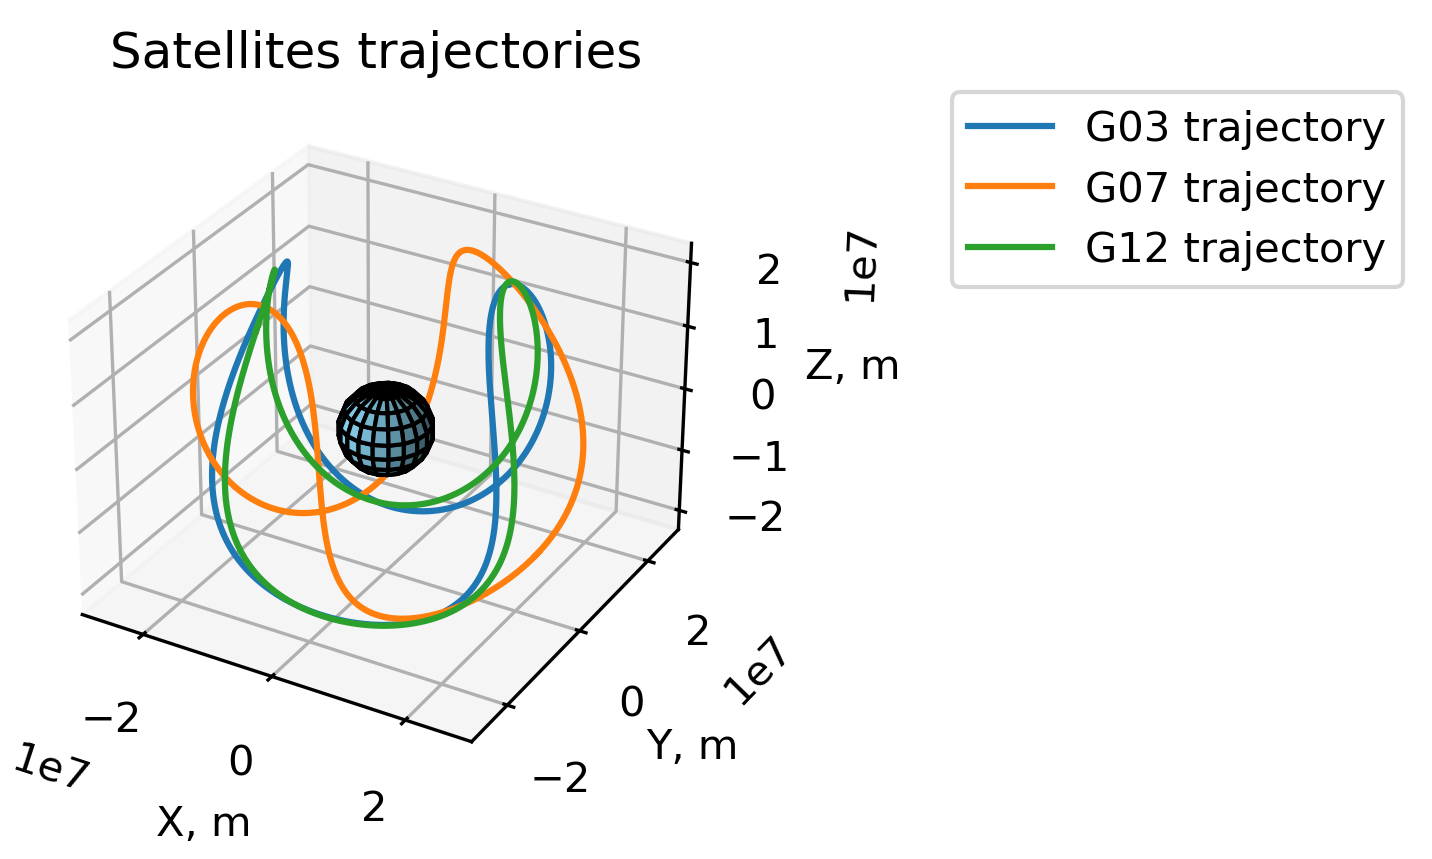

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plot_sats = ["G03", "G07", "G12"]
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(projection='3d')
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = RE * np.cos(u)*np.sin(v)
y = RE * np.sin(u)*np.sin(v)
z = RE * np.cos(v)
ax.plot_surface(x, y, z, color="skyblue", edgecolor="black")
for sat in plot_sats:
    ax.plot(sats_xyz[sat][:, 0], sats_xyz[sat][:, 1], sats_xyz[sat][:, 2], label=f"{sat} trajectory")
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_zlabel('Z, m')
plt.legend(bbox_to_anchor=(1.3, 1.03))
ax.set_title(f'Satellites trajectories')

## Convert XYZ to elevation and azimuth 

In [15]:
def xyz_to_el_az(
    xyz_site: tuple[float], 
    xyz_sat: NDArray[float], 
    earth_radius=RE
) -> tuple[NDArray[float]]:
    """Computes elevation and azimuth to satellite.

    Parameters
    ----------
    xyz_site : tuple (x, y, z); cartesian coordinates of the observer
    xyz_sat : NDArray of (N, 3) shape; cartesian coordinates of the satellite
    Returns 
    -------
    elevation and azimuth as 2 numpy arrays
    """
    def cartesian_to_latlon(x, y, z, earth_radius=earth_radius):
        r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        lon = np.arctan2(y, x)
        lat = np.arcsin(z / r)
        return lat, lon, r - earth_radius


    (x_0, y_0, z_0) = xyz_site
    (x_s, y_s, z_s) = xyz_sat[:, 0], xyz_sat[:, 1], xyz_sat[:, 2]

    (b_0, l_0, h_0) = cartesian_to_latlon(*xyz_site)
    (b_s, l_s, h_s) = cartesian_to_latlon(x_s, y_s, z_s)

    r_k = np.sqrt(x_s ** 2 + y_s ** 2 + z_s ** 2)

    sigma = np.arctan2(
        np.sqrt(1 - (np.sin(b_0) * np.sin(b_s) + np.cos(b_0) * np.cos(b_s) * np.cos(l_s - l_0)) ** 2), 
        (np.sin(b_0) * np.sin(b_s) + np.cos(b_0) * np.cos(b_s) * np.cos(l_s - l_0))
    )

    x_t = -(x_s - x_0) * np.sin(l_0) + (y_s - y_0) * np.cos(l_0)
    y_t = (
        -1 * (x_s - x_0) * np.cos(l_0) * np.sin(b_0) -
        (y_s - y_0) * np.sin(l_0) * np.sin(b_0) + 
        (z_s - z_0) * np.cos(b_0)
    )

    el = np.arctan2(
        (np.cos(sigma) - earth_radius / r_k),  
        np.sin(sigma)
    )
    az = np.arctan2(x_t, y_t)

    az = np.where(az < 0, az + 2*np.pi, az)
    return np.concatenate([[el], [az]]).T # to keep same notation as for xyz i.e. azimuth = elaz[:, 1]

def get_sat_elevation_azimuth(
    site_location_xyz: tuple[float], 
    sats_xyz: dict[str, NDArray],  
) -> dict[str, NDArray]:
    """ Calculates elevation and azimuth for satellite for give site location
    """
    elaz = {}
    for sat, sat_xyz in sats_xyz.items():
        elaz[sat] = xyz_to_el_az(site_location_xyz, sat_xyz)
    return elaz

In [16]:
sats_elaz = get_sat_elevation_azimuth(SITE_XYZ, sats_xyz)
print(f"Calculated satellites elevation and azimuths for {SITE_NAME} and satellites: {list(sats_elaz.keys())}")

Calculated satellites elevation and azimuths for irkj and satellites: ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R20', 'R21', 'R22', 'R23', 'R24', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'E13', 'E14', 'E15', 'E16', 'E18', 'E19', 'E21', 'E23', 'E24', 'E25', 'E26', 'E27', 'E29', 'E30', 'E31', 'E33', 'E34', 'E36', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40']


## Elevation azimuth visulaization (not intuitive)

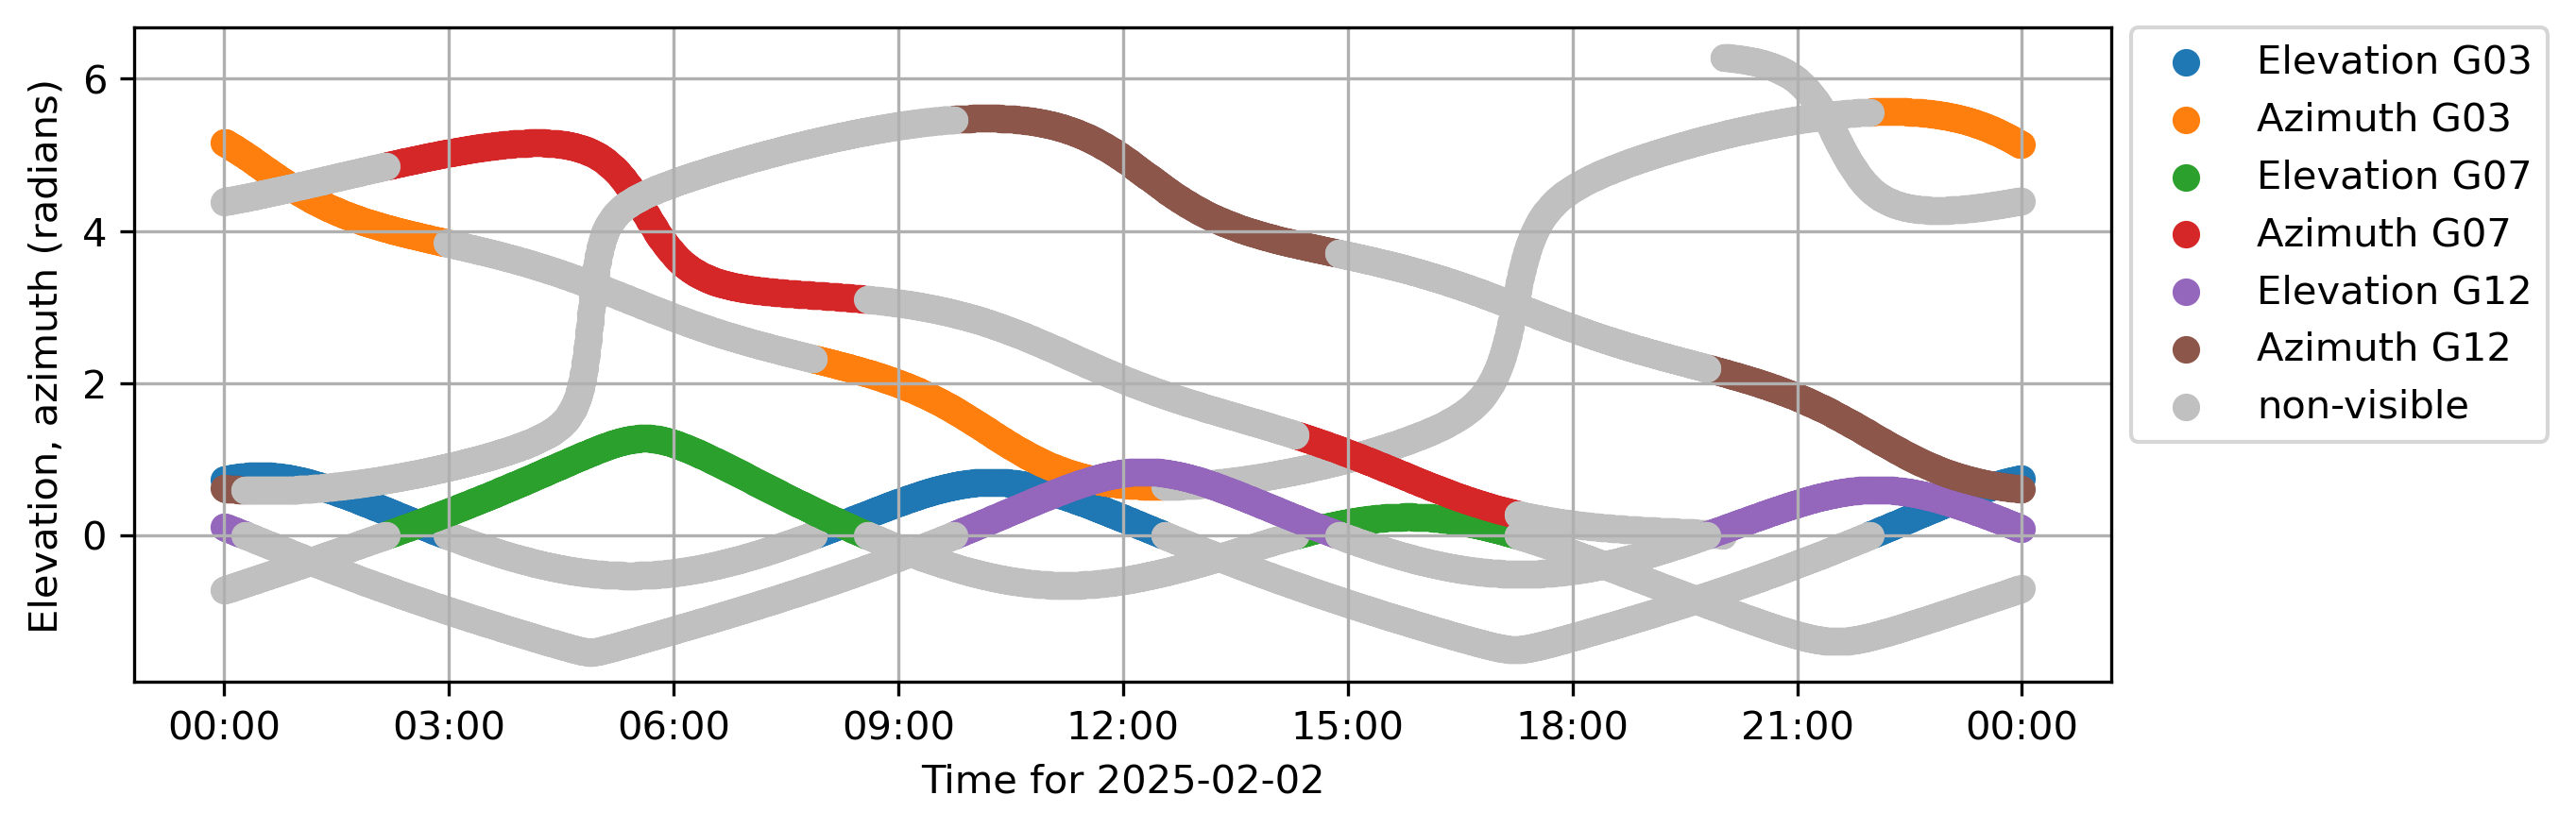

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(9, 3), dpi=300)
for sat in plot_sats:
    elaz = sats_elaz[sat]
    mask = np.where(elaz[:, 0] > 0)
    invisible = np.where(elaz[:, 0] < 0)
    times_arr = np.array(times) 
    ax.scatter(times_arr[mask], elaz[:, 0][mask], label = f"Elevation {sat}")
    ax.scatter(times_arr[mask], elaz[:, 1][mask], label = f"Azimuth {sat}")
    ax.scatter(times_arr[invisible], elaz[:, 0][invisible], c="silver")
    ax.scatter(times_arr[invisible], elaz[:, 1][invisible], c="silver")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_ylabel("Elevation, azimuth (radians)")
    ax.set_xlabel(f"Time for {STUDY_DATE.date()}")
ax.scatter(times_arr[invisible], elaz[:, 1][invisible], c="silver", label="non-visible")
plt.grid()
plt.legend(bbox_to_anchor=(1, 1.03))

## Calculate latitude and longitude of subionospheric point

In [18]:
import numpy as np
from numpy.typing import NDArray

def calculate_sips(
    site_lat: NDArray | float,           
    site_lon: NDArray | float,           
    elevation: NDArray,          
    azimuth: NDArray,            
    ionospheric_height: float = HEIGHT_OF_THIN_IONOSPHERE, 
    earth_radius: float = RE  
) -> NDArray:
    """
    Calculates subionospheric point and delatas from site
    Parameters:
        s_lat, slon - site latitude and longitude in radians
        hm - ionposheric maximum height (meters)
        az, el - azimuth and elevation of the site-sattelite line of sight in
            radians
        R - Earth radius (meters)
    """
    psi = (
        (np.pi / 2 - elevation) - 
        np.arcsin(np.cos(elevation) * earth_radius / (earth_radius + ionospheric_height))
    )
    lat = np.arcsin(
        np.sin(site_lat) * np.cos(psi) + 
        np.cos(site_lat) * np.sin(psi) * np.cos(azimuth)
    )
    lon = site_lon + np.arcsin(np.sin(psi) * np.sin(azimuth) / np.cos(site_lat))

    # Normalize longitude to [-pi, pi]
    lon = np.where(lon > np.pi, lon - 2 * np.pi, lon)
    lon = np.where(lon < -np.pi, lon + 2 * np.pi, lon)

    return np.concatenate([[np.degrees(lat)], [np.degrees(lon)]]).T

def get_sat_sips(
    site_latlon: tuple[float],
    sats_elaz: dict[str, NDArray],  
) -> dict[str, NDArray]:
    sip_latlon = {}
    site_lat, site_lon = site_latlon
    for sat, elaz in sats_elaz.items():
        sips = calculate_sips(np.radians(site_lat), np.radians(site_lon), elaz[:, 0], elaz[:, 1])
        sip_latlon[sat] = sips
    return sip_latlon


In [19]:
print(SITE_LATLON)
sat_sips = get_sat_sips(SITE_LATLON, sats_elaz)
print(f"Calculated satellites SIPs for {SITE_NAME} and satellites: {list(sat_sips.keys())}")

[52.21901939978789, 104.31619607109269]
Calculated satellites SIPs for irkj and satellites: ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R20', 'R21', 'R22', 'R23', 'R24', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11', 'E13', 'E14', 'E15', 'E16', 'E18', 'E19', 'E21', 'E23', 'E24', 'E25', 'E26', 'E27', 'E29', 'E30', 'E31', 'E33', 'E34', 'E36', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40']


/tmp/ipykernel_859128/3100462330.py:29: RuntimeWarning: invalid value encountered in arcsin
  lon = site_lon + np.arcsin(np.sin(psi) * np.sin(azimuth) / np.cos(site_lat))


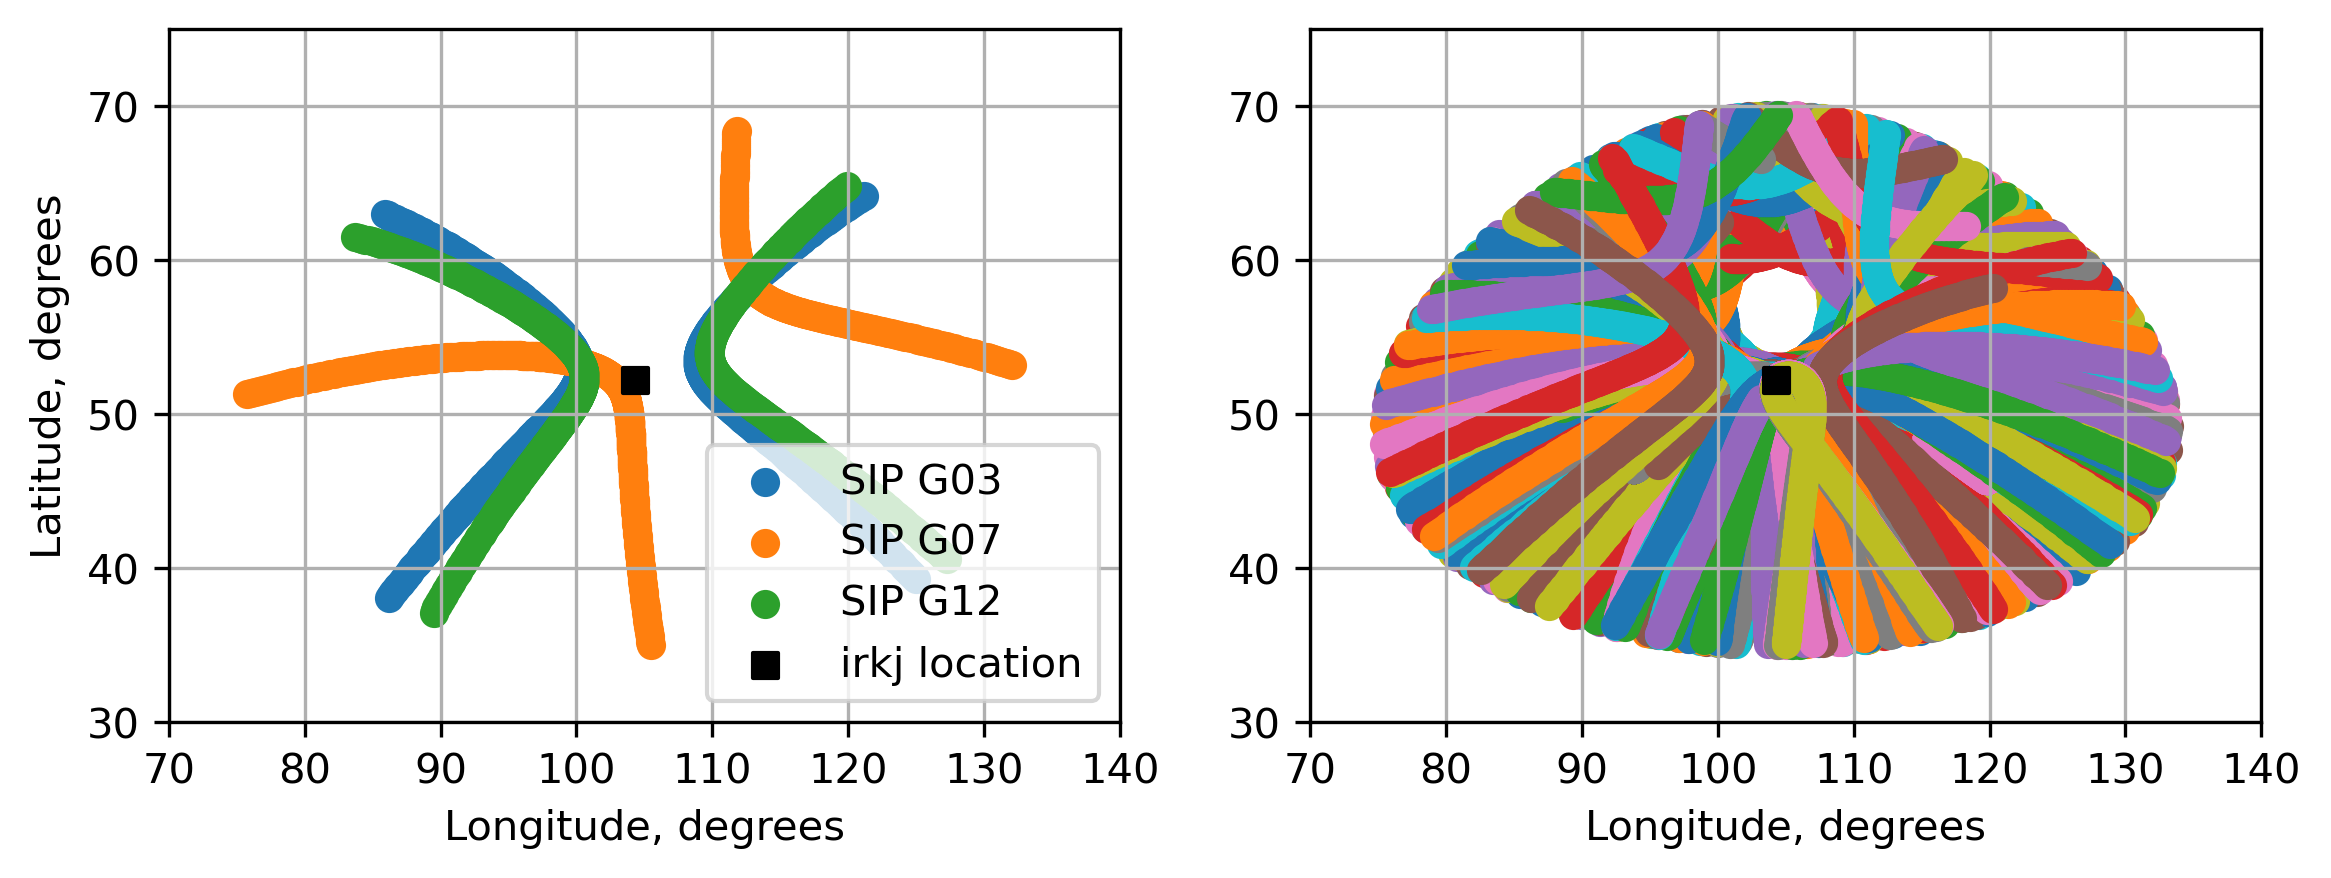

In [20]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), dpi=300)
ax_selected = axs[0]
ax_all = axs[1]
for sat in sat_sips:
    sips = sat_sips[sat]
    elaz = sats_elaz[sat]
    mask = np.where(elaz[:, 0] > 0) # plot only SIPs for visible parts
    ax_all.scatter(sips[:, 1][mask], sips[:, 0][mask], label = f"SIP {sat}")
    if sat in plot_sats:
        ax_selected.scatter(sips[:, 1][mask], sips[:, 0][mask], label = f"SIP {sat}")
for ax in axs:
    ax.scatter(SITE_LATLON[1], SITE_LATLON[0], c="black", marker="s", label= f"{SITE_NAME} location")
    ax.grid()
    ax.set_xlabel("Longitude, degrees")
    ax.set_xlim(70, 140)
    ax.set_ylim(30, 75)
ax_selected.set_ylabel("Latitude, degrees")
ax_selected.legend()

## Calculate great circle distance to select SIPs close to event or region of interest

In [21]:
def calculate_great_circle_distance(
    late: NDArray,
    lone: NDArray,
    latp: NDArray,
    lonp: NDArray,
    radius: float = RE
) -> NDArray[float]:
    """ Calculates arc length. 
    
    It can work with numpy arrays as well as with scalars
    late, latp: double
        latitude in radians
    lone, lonp: double
        longitudes in radians
    R: double
        radius
    """
    lone[np.where(lone < 0)] = lone[np.where(lone < 0)] + 2*np.pi
    lonp[np.where(lonp < 0)] = lonp[np.where(lonp < 0)] + 2*np.pi
    dlon = lonp - lone
    inds = np.where((dlon > 0) & (dlon > np.pi)) 
    dlon[inds] = 2 * np.pi - dlon[inds]
    dlon[np.where((dlon < 0) & (dlon < -np.pi))] += 2 * np.pi
    dlon[np.where((dlon < 0) & (dlon < -np.pi))] = -dlon[np.where((dlon < 0) & (dlon < -np.pi))]
    cosgamma = np.sin(late) * np.sin(latp) + np.cos(late) * np.cos(latp) * np.cos(dlon)
    return radius * np.arccos(cosgamma)

def get_event_sat_gcd(
    event_latlon: tuple[float],
    sat_sips_latlon: dict[str, NDArray],  
) -> dict[str, NDArray]:
    sat_event_gcd = {}
    event_lat, event_lon = event_latlon
    
    for sat, sip_latlon in sat_sips_latlon.items():
        elat_array = np.full_like(sip_latlon[:, 0], event_lat)
        elon_array = np.full_like(sip_latlon[:, 0], event_lon)
        gcd = calculate_great_circle_distance(
            np.radians(elat_array), np.radians(elon_array), 
            np.radians(sip_latlon[:, 0]), np.radians(sip_latlon[:, 1])
        )
        sat_event_gcd[sat] = gcd
    return sat_event_gcd


In [22]:
sat_sip_event_gcd = get_event_sat_gcd(EVENT_LATLON, sat_sips)

## Find mask to select SIP

In [23]:
def calculte_sats_mask(
    sat_event_gcd: dict[str, NDArray],
    max_distance: float 
) -> dict[str, NDArray]:
    """Return list of indexes for each satellite to take into consideration"""
    sat_mask = {}
    for sat, gcd in sat_event_gcd.items():
        mask = np.where(gcd < max_distance)[0]
        sat_mask[sat] = mask        
    return sat_mask

In [24]:
sat_sip_event_mask = calculte_sats_mask(sat_sip_event_gcd, MAX_DISTANCE_FROM_EVENT)

In [25]:
from dataclasses import dataclass

@dataclass
class PointOfInterest:
    site: str
    sat: str
    time: datetime
    distance: float
    latitude: float
    longitude: float
    height: float

def get_point_of_interest(
    site: str,
    height: float,
    sat_mask: dict[str, NDArray],
    times: list[datetime],
    sat_event_gcd: dict[str, NDArray],
    sat_sips: dict[str, NDArray],
):
    points = {}
    for sat, mask in sat_mask.items():
        points[sat] = []
        for i in mask:
            sip_lat = sat_sips[sat][i, 0]
            sip_lon = sat_sips[sat][i, 1]
            point = PointOfInterest(site, sat, times[i], sat_event_gcd[sat][i], sip_lat, sip_lon, height)
            points[sat].append(point)
    return points
    

## Finally we are ready to get SIP that are close to event

In [26]:
sat_selected_sips = get_point_of_interest(
    SITE_NAME, 
    HEIGHT_OF_THIN_IONOSPHERE,
    sat_sip_event_mask, 
    times, 
    sat_sip_event_gcd, 
    sat_sips
)

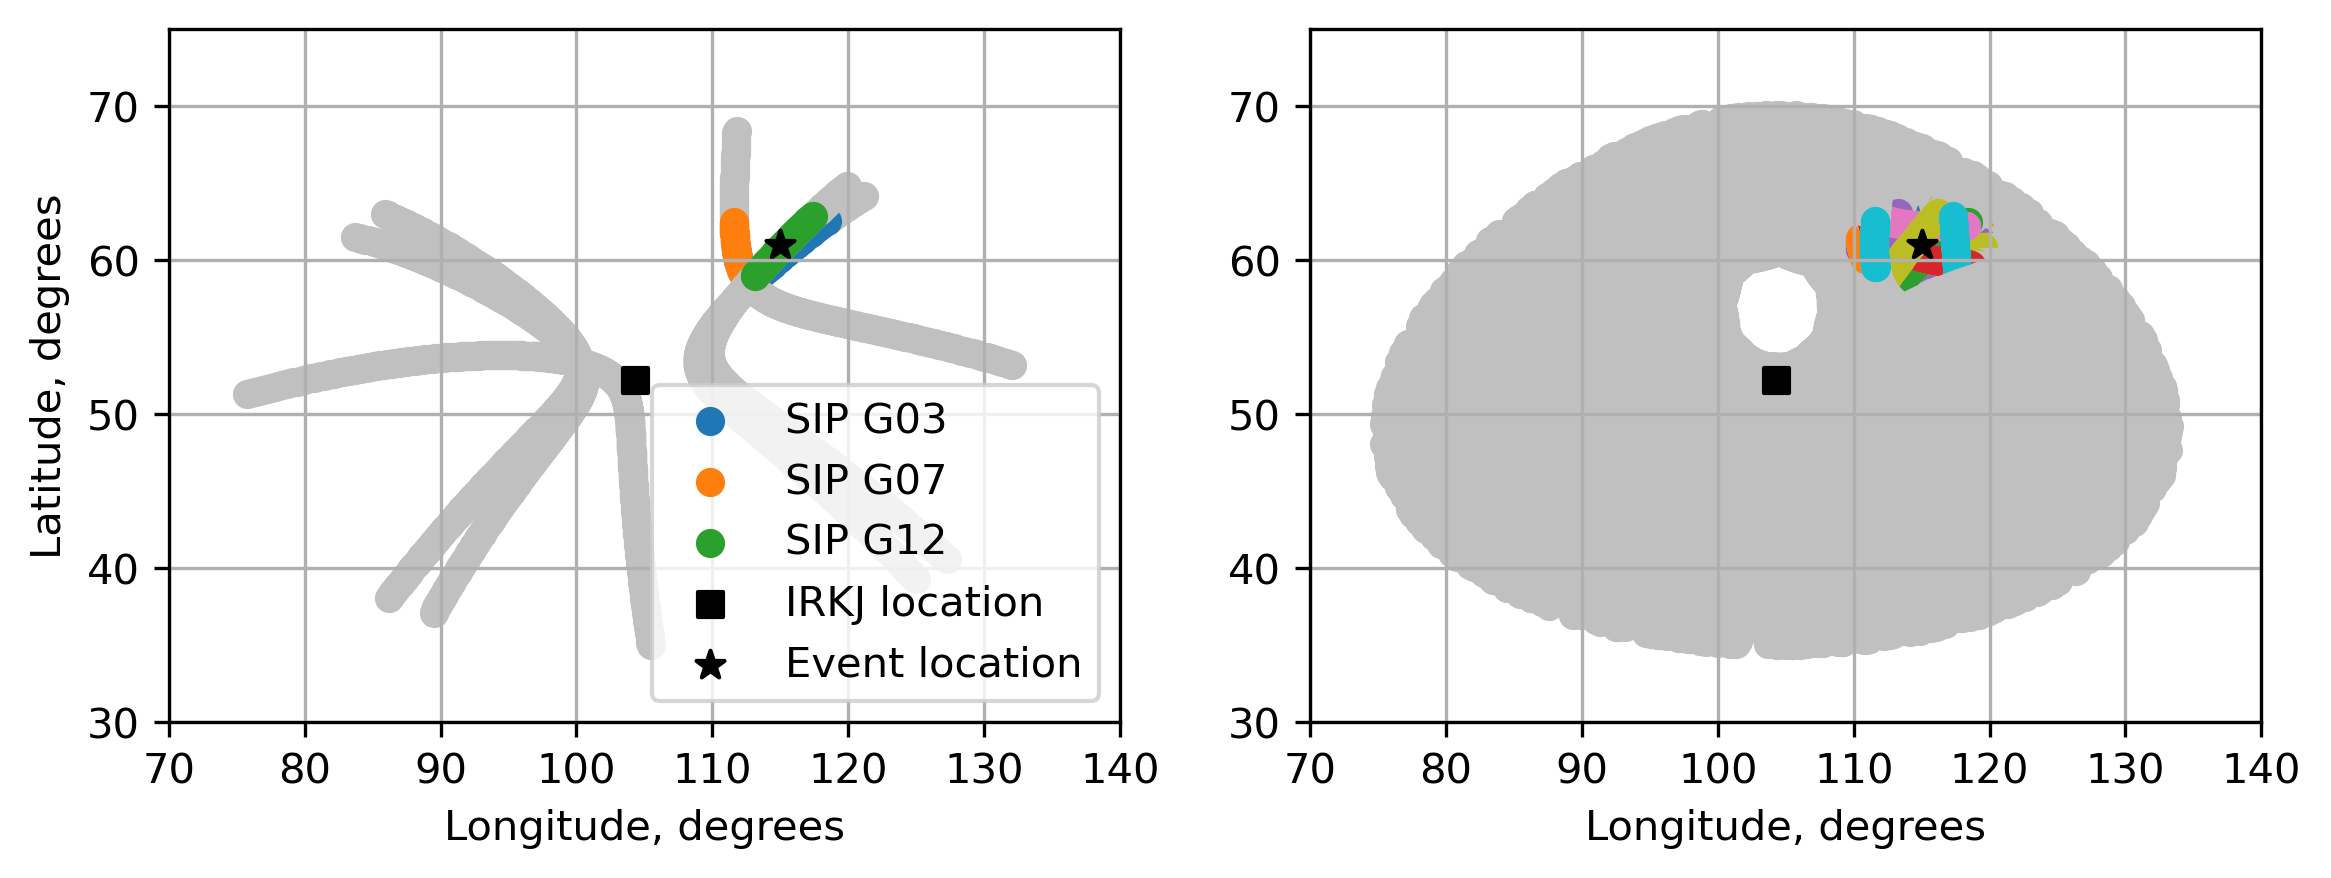

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3), dpi=300)
ax_selected = axs[0]
ax_all = axs[1]
for sat, points in sat_selected_sips.items():
    selected_lats = []
    selected_lons = []
    for point in points:
        selected_lats.append(point.latitude) 
        selected_lons.append(point.longitude) 
    sips = sat_sips[sat]
    elaz = sats_elaz[sat]
    mask = np.where(elaz[:, 0] > 0) # plot only SIPs for visible parts
    ax_all.scatter(sips[:, 1][mask], sips[:, 0][mask], c="silver")
    ax_all.scatter(selected_lons, selected_lats, label = f"SIP {sat}")
    if sat in plot_sats:
        ax_selected.scatter(sips[:, 1][mask], sips[:, 0][mask], c="silver")
        ax_selected.scatter(selected_lons, selected_lats, label = f"SIP {sat}")
for ax in axs:
    ax.scatter(SITE_LATLON[1], SITE_LATLON[0], c="black", marker="s", label= f"{SITE_NAME.upper()} location")
    ax.scatter(EVENT_LATLON[1], EVENT_LATLON[0], c="black", marker="*", s=50,  label= f"Event location")
    ax.grid()
    ax.set_xlabel("Longitude, degrees")
    ax.set_xlim(70, 140)
    ax.set_ylim(30, 75)
ax_selected.set_ylabel("Latitude, degrees")
ax_selected.legend()